In [1]:
!pip install fastai==1.0.47

    100% |████████████████████████████████| 215kB 28.0MB/s ta 0:00:01
  Found existing installation: fastai 1.0.51
    Uninstalling fastai-1.0.51:
      Successfully uninstalled fastai-1.0.51


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
from pathlib import Path
# Any results you write to the current directory are saved as output.
PATH = Path('../input')

['y_train.csv', 'sample_submission.csv', 'X_test.csv', 'X_train.csv']


In [3]:
import fastai
from fastai.tabular import *
import tqdm

In [4]:
!head -n 5 ../input/X_train.csv

row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.10765,0.017561,0.00076741,-0.74857,2.103,-9.7532
0_1,0,1,-0.75853,-0.63434,-0.1049,-0.106,0.067851,0.029939,0.0033855,0.33995,1.5064,-9.4128
0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.0072747,0.028934,-0.0059783,-0.26429,1.5922,-8.7267
0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.0089735,0.42684,1.0993,-10.096


In [5]:
features = ['orientation_X',
'orientation_Y',
'orientation_Z',
'orientation_W',
'angular_velocity_X',
'angular_velocity_Y',
'angular_velocity_Z',
'linear_acceleration_X',
'linear_acceleration_Y',
'linear_acceleration_Z']

In [6]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [7]:
def augment_df(actual):
    actual['total_angular_velocity'] = (actual['angular_velocity_X'] ** 2 + actual['angular_velocity_Y'] ** 2 + actual['angular_velocity_Z'] ** 2) ** 0.5
    actual['total_linear_acceleration'] = (actual['linear_acceleration_X'] ** 2 + actual['linear_acceleration_Y'] ** 2 + actual['linear_acceleration_Z'] ** 2) ** 0.5
    
    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    actual['total_angle'] = (actual['euler_x'] ** 2 + actual['euler_y'] ** 2 + actual['euler_z'] ** 2) ** 5
    actual['angle_vs_acc'] = actual['total_angle'] / actual['total_linear_acceleration']
    actual['angle_vs_vel'] = actual['total_angle'] / actual['total_angular_velocity']
    return actual

In [8]:
augment_features = [
    'total_angular_velocity',
    'total_linear_acceleration',
    'acc_vs_vel',
    'euler_x',
    'euler_y',
    'euler_z',
    'total_angle',
    'angle_vs_acc',
    'angle_vs_vel'
]

In [9]:
total_features = features+augment_features

In [10]:
def gen_features(df):
    strain = []
    for feature in total_features:
        X = df[feature]
        abs_diff = np.abs(np.diff(X))
        min_x = X.min()
        max_x = X.max()
        strain.append(X.mean()) #0
        strain.append(X.std()) #1
        strain.append(min_x) #2
        strain.append(max_x) #3
        strain.append(X.kurtosis()) #4
        strain.append(X.skew()) #5
        strain.append(np.quantile(X,0.01)) #6
        strain.append(np.quantile(X,0.05)) #7
        strain.append(np.quantile(X,0.95)) #10
        strain.append(np.quantile(X,0.99)) #11
        strain.append(np.abs(X).max()) #12
        strain.append(np.abs(X).mean()) #13
        strain.append(np.abs(X).std()) #14
        strain.append(np.square(X).kurtosis()) #15
        strain.append(X.mad()) #16
        strain.append(np.mean(np.diff(abs_diff)))#17
        strain.append(np.mean(abs_diff))#18
        strain.append(max_x/min_x)#19
    return pd.Series(strain)

In [11]:
x_train_dfs = pd.read_csv(PATH/'X_train.csv',index_col='row_id',chunksize=128,iterator=True)
x_test_dfs = pd.read_csv(PATH/'X_test.csv',index_col='row_id',chunksize=128,iterator=True)

In [12]:
y_train_df = pd.read_csv(PATH/'y_train.csv')
y_train_df.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [13]:
X_train = pd.DataFrame()
y_train = pd.Series()
for df in tqdm.tqdm_notebook(x_train_dfs):
    ch = augment_df(df)
    ch = gen_features(ch)
    X_train = X_train.append(ch, ignore_index=True)

In [14]:
train_data = X_train
train_data['surface'] = y_train_df['surface']
del(X_train)

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Columns: 343 entries, 0 to surface
dtypes: float64(342), object(1)
memory usage: 10.0+ MB


In [16]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,surface
0,-0.758666,0.000363,-0.75953,-0.75822,-0.646196,-0.659082,-0.759497,-0.759363,-0.758240,-0.758223,0.75953,0.758666,0.000363,-0.644965,0.000311,2.380952e-07,0.000015,0.998275,-0.634008,0.000471,-0.63456,-0.63306,-1.185867,0.603197,-0.634555,-0.634523,-0.633190,-0.633075,0.63456,0.634008,0.000471,-1.186621,0.000421,0.000000e+00,0.000018,0.997636,-0.105474,0.000432,-0.106140,-0.104610,...,0.186413,33.501276,1.013595,10296.380999,1122.040965,8090.592033,14292.161203,2.155615,1.207107,8428.391402,8804.938118,12486.888424,14063.485343,14292.161203,10296.380999,1122.040965,3.518031,829.654340,3.958445,742.697670,1.766516,2.278501e+06,1.409996e+06,6.255962e+05,9.597909e+06,9.675543,2.582325,6.882573e+05,9.612992e+05,4.385799e+06,8.585260e+06,9.597909e+06,2.278501e+06,1.409996e+06,30.356154,9.592402e+05,8924.000999,1.198969e+06,15.342019,fine_concrete
1,-0.958606,0.000151,-0.95896,-0.95837,-0.642996,-0.397289,-0.958957,-0.958880,-0.958390,-0.958380,0.95896,0.958606,0.000151,-0.642648,0.000126,-4.761905e-07,0.000023,0.999385,0.241867,0.000499,0.24074,0.24270,-0.536113,-0.422565,0.240760,0.240958,0.242563,0.242695,0.24270,0.241867,0.000499,-0.540482,0.000401,1.587302e-07,0.000070,1.008142,0.031650,0.000508,0.030504,0.032341,...,-0.452778,29.027896,1.015658,4062.512107,776.901945,2339.913394,6783.879086,1.420490,0.950165,2625.593315,3128.451200,5429.435185,6348.889214,6783.879086,4062.512107,776.901945,3.393757,583.540979,-14.428888,569.691449,2.899201,4.613413e+05,2.979271e+05,1.377975e+05,1.957088e+06,8.817459,2.575305,1.535594e+05,1.876144e+05,1.030406e+06,1.761938e+06,1.957088e+06,4.613413e+05,2.979271e+05,27.024210,1.958459e+05,569.164381,2.049951e+05,14.202636,concrete
2,-0.512057,0.001377,-0.51434,-0.50944,-1.052580,0.151971,-0.514274,-0.514065,-0.509841,-0.509506,0.51434,0.512057,0.001377,-1.053893,0.001144,0.000000e+00,0.000041,0.990473,-0.846171,0.000785,-0.84779,-0.84490,-1.082132,-0.161786,-0.847674,-0.847460,-0.845031,-0.844915,0.84779,0.846171,0.000785,-1.081347,0.000673,-7.142857e-07,0.000024,0.996591,-0.129371,0.000541,-0.130300,-0.128520,...,-4.386186,89.751305,1.018473,28544.738837,2827.720137,22485.416514,42270.643412,3.407299,1.000061,23330.311095,24555.500804,32813.835801,35102.807743,42270.643412,28544.738837,2827.720137,7.122116,2169.366691,-27.986872,2051.526278,1.879914,5.372327e+06,3.802655e+06,1.674839e+06,2.866679e+07,11.562199,2.816102,1.886714e+06,2.052966e+06,1.387492e+07,1.705019e+07,2.866679e+07,5.372327e+06,3.802655e+06,50.225740,2.524832e+06,-9135.272306,2.355426e+06,17.116144,concrete
3,-0.939169,0.000227,-0.93968,-0.93884,-1.078090,-0.096106,-0.939634,-0.939539,-0.938850,-0.938850,0.93968,0.939169,0.000227,-1.077773,0.000197,-6.349206e-07,0.000026,0.999106,0.310140,0.000453,0.30943,0.31147,1.540409,1.230981,0.309460,0.309561,0.311223,0.311457,0.31147,0.310140,0.000453,1.550159,0.000309,0.000000e+00,0.000036,1.006593,0.038955,0.000449,0.037922,0.039799,...,-1.322929,61.129619,1.036396,4617.055454,2456.865940,2157.840573,21883.823520,26.566967,4.583553,2338.498703,2751.858388,7676.677548,16897.262115,21883.823520,4617.055454,2456.865940,53.050688,1294.640243,-11.177366,1251.374915,10.141539,4.765087e+05,4.627398e+05,8.652378e+04,3.121275e+06,14.724867,3.407821,1.005397e+05,1.246933e+05,1.062816e+06,2.715766e+06,3.121275e+06,4.765087e+05,4.627398e+05,37.158900,2.825849e+05,17412.401283,2.981020e+05,36.074189,concrete
4,-0.891301,0.002955,-0.89689,-0.88673,-1.165941,-0.226700,-0.896773,-0.896241,-0.887157,-0.886832,0.89689,0.891301,0.002955,-1.163688,0.002562,7.936508e-08,0.000080,0.988672,0.428144,0.006165,0.41646,0.43740,-1.139899,-0.242538,0.416692,0.417744,0.436699,0.437225,0.43740,0.428144,0.006165,-1.150365,0.005308,2.380952e

In [17]:
X_test = pd.DataFrame()
for df in tqdm.tqdm_notebook(x_test_dfs):
    ch = augment_df(df)
    ch = gen_features(ch)
    X_test = X_test.append(ch, ignore_index=True)

In [18]:
procs = [Normalize]
cont_vars = [x for x in range(train_data.shape[1]-1)]

In [19]:

data = (TabularList.from_df(train_data,procs=procs,cont_names=cont_vars)
                .split_by_rand_pct(0.01)
                .label_from_df(cols='surface')
                .add_test(TabularList.from_df(X_test))
                .databunch())

In [20]:
len(data.train_ds.cont_names)

342

In [21]:
data.classes,data.c

(['carpet',
  'concrete',
  'fine_concrete',
  'hard_tiles',
  'hard_tiles_large_space',
  'soft_pvc',
  'soft_tiles',
  'tiled',
  'wood'],
 9)

In [22]:
learn = tabular_learner(data, layers=[1024,512], ps=[0.001,0.01], emb_drop=0.1,metrics=[accuracy])

In [23]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.1)
  (bn_cont): BatchNorm1d(342, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=342, out_features=1024, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=512, out_features=9, bias=True)
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03


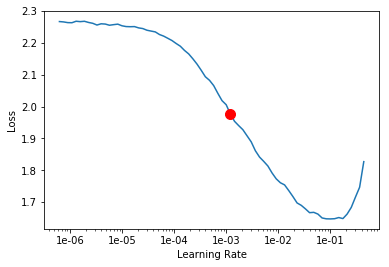

In [24]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [25]:
learn.fit_one_cycle(15, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,1.660507,1.413727,0.552632,00:00
1,1.187595,0.804445,0.815789,00:00
2,0.857462,0.684255,0.763158,00:00
3,0.642592,0.509334,0.868421,00:00
4,0.521033,0.545960,0.763158,00:00
5,0.411891,0.529283,0.763158,00:00
6,0.327349,0.394644,0.868421,00:00
7,0.274262,0.377358,0.815789,00:00
8,0.215301,0.384271,0.868421,00:00
9,0.164608,0.353173,0.868421,00:00


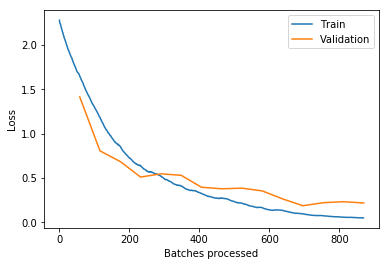

In [26]:
learn.recorder.plot_losses()

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


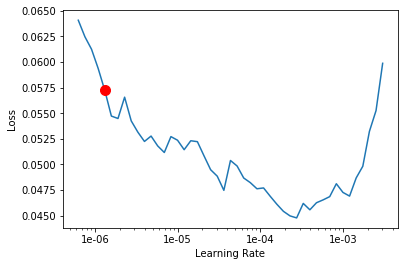

In [28]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [30]:
learn.fit_one_cycle(5,1e-4,wd=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,0.051326,0.214948,0.894737,00:00
1,0.051492,0.198783,0.894737,00:00
2,0.045003,0.186020,0.921053,00:00
3,0.043963,0.189472,0.921053,00:00
4,0.038702,0.244260,0.894737,00:00


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

In [ ]:
test_preds=learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
test_preds[0].argmax(1).size()

In [ ]:
test_preds_list = test_preds[0].argmax(1)

In [ ]:
labelled_preds = [learn.data.classes[pred] for pred in test_preds_list]

In [ ]:
sub_csv = pd.read_csv(PATH/'sample_submission.csv')

In [ ]:
sub_csv.head()

In [ ]:
sub_csv['surface'] = labelled_preds

In [ ]:
sub_csv.to_csv('results.csv',index=False)